In [84]:
# Codice per clonare la repository di github con tutti i dati. Va eseguito una sola volta
# (per questo si controlla se la cartella esista già o meno)
# È stato scelto questo metodo per permettere a tutti, sia da google colab che in locale,
# di avere i dati a disposizione

# Se si esegue in locale, assicurarsi di avere git installato
# Al link della repository sono visionabili tutti i file
from os import path
if not path.exists("Laboratorio_Fisica_3"):
    !git clone https://github.com/MasterRoby3/Laboratorio_Fisica_3

# Per comodità si definisce una variabile che sia la radice di tutti i percorsi utilizzati, in modo da alleggerire il codice successivo
rad = "Laboratorio_Fisica_3/Fotodiodo_inversa/"

# In questa prima cella si importano anche le librerie necessarie:
import numpy as np
from scipy import optimize as sop
from scipy import constants as scc
import matplotlib.pyplot as plt
import pandas as pd

# Si memorizzano anche alcune costanti utili più avanti
electron_charge = scc.e
Boltzmann = scc.Boltzmann
temperature = 300

#Altri dati utili per i plot
titlefontsize, labelfontsize, tickfontsize=20, 16, 14
markersize, linewidth = 6, 1

# Fotodiodo polarizzato in inversa

In questa esperienza si vuole studiare la risposta del fotodiodo quando è polarizzato inversamente ed è presente una resistenza di carico.
Sapendo che:
* nel fotodiodo e nella resistenza scorre la stessa corrente, ovvero $I_D = I_R$
* $I_D = I_0 \left(e^{\frac{qV_D}{kT}} - 1\right) - I_{ph}$
* $I_R = -\frac{V_R}{R}$ (il segno è dovuto al fatto che la corrente si assume positiva in senso orario nel circuito sotto, quindi la fotocorrente è negativa; si ha quindi che anche $I_D = I_R$ è negativa)
* $V_D = V_R + V_g$, dove $V_g$ è la tensione del generatore, negativa perché si sta polarizzando il diodo in inversa
* $I_{ph} = \beta I_{LED}$, come mostrato nell'esperienza sull'accoppiamento del LED e del fotodiodo

si giunge alla relazione:
$$I_{ph} = \beta I_{LED} = I_0 \left(e^{\frac{q(V_R + V_g)}{kT}} - 1\right) + \frac{V_R}{R}$$

##### Struttura dell'esperienza
Lo schema del circuito utilizzato è il seguente:

<br><center><img src="Laboratorio_Fisica_3/Fotodiodo_inversa/img/pd-inversa.png"/></center><br>

Il led viene alimentato da un generatore in continua che lo polarizza in diretta; si usa una resistenza di protezione $R_{LED}$ da 500 $\Omega$ (massima corrente del led 20 mA).

Si procede quindi nelle celle di codice seguenti a riportare dati e grafici.

In [85]:
# Definizione dei nomi dei file da importare
filenames = ['R10k_data.csv', 'R20k_data.csv']
# Valori delle resistenze
Rs = [10000, 20000]

# Lettura dei dati da file
data = []
for filename in filenames:
    data.append(pd.read_csv(rad+"data/"+filename))

# Definizione degli array contenenti i dati da graficare successivamente
Is = []
V_gen = []
V_tot = []

#le due liste contenute in V_gs contengono i vari valori di V_g per le due resistenze
V_gs = [[0, -0.5, -1, -3, -5], [0, -0.5, -1, -1.5, -2, -3, -5]]

for index, df in enumerate(data):
    # Si memorizzano gli headers
    headers=df.keys()

    # Riempimento delle liste definite prima con i dati letti da file
    V = []
    for head in headers:
        if head == 'I':
            Is.append(df[head].to_numpy())
        else:
            V.append(df[head].to_numpy())

    V_tot.append(V)

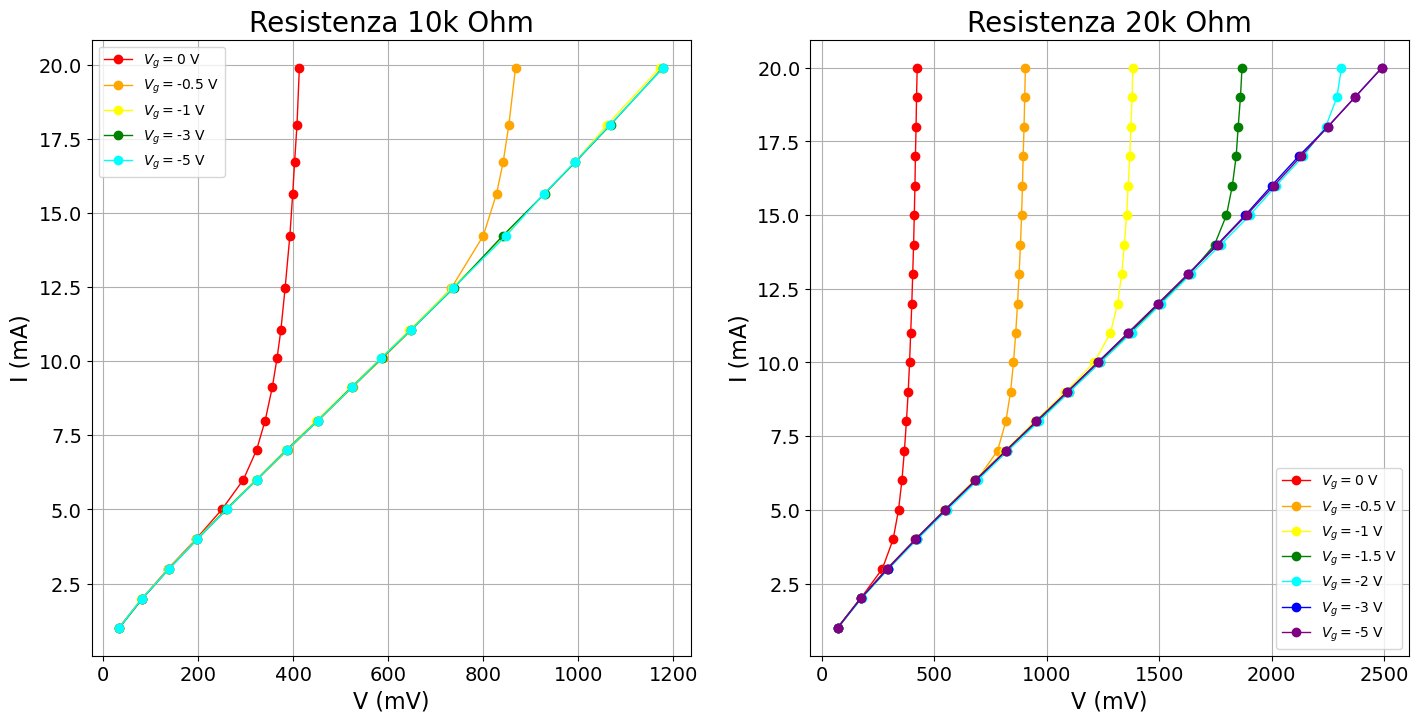

In [86]:
# In questa cella si procede al plot per la visualizzazione dei dati letti
# Si definisce un array di colori che veranno usati per il plot
colors = ["red", "orange", "yellow", "green", "cyan", "blue", "purple"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[17,8])

ax1.set_title("Resistenza 10k Ohm", size=titlefontsize)
for index, arr in enumerate(V_tot[0]):
    ax1.plot(arr, Is[0], '-o', markersize=markersize, linewidth=linewidth, color=colors[index], label="$V_g = $"+str(V_gs[0][index])+" V")

ax1.set_xlabel('V (mV)', size=labelfontsize)
ax1.set_ylabel('I (mA)', size=labelfontsize)
ax1.tick_params(labelsize=tickfontsize)
ax1.grid(True)
ax1.legend()

ax2.set_title("Resistenza 20k Ohm", size=titlefontsize)
for index, arr in enumerate(V_tot[1]):
    ax2.plot(arr, Is[1], '-o', markersize=markersize, linewidth=linewidth, color=colors[index], label="$V_g = $"+str(V_gs[1][index])+" V")

ax2.set_xlabel('V (mV)', size=labelfontsize)
ax2.set_ylabel('I (mA)', size=labelfontsize)
ax2.tick_params(labelsize=tickfontsize)
ax2.grid(True)
ax2.legend();

#### Funzioni di fit

Per effettuare i fit si necessita di una funzione lineare per ricavare il valore di $\beta$, dato che a grandi valori di $V_g$ si ha $\beta I_{LED} = \frac{V_R}{R}$. Inserendo anche un termine di fondo, si ottiene la funzione di fit:
$$I_{LED} = \frac{V_R}{R * \beta} + V_{fondo}$$.

Una volta ottenuto $\beta$, si possono fittare i dati a qualsiasi valore di $V_g$ con l'equazione completa:
$$I_{LED} = \frac{1}{\beta} \left[I_0\left(e^{\frac{q(V_R + V_g)}{nkT}} - 1\right) + \frac{V_R}{R}\right]$$
È stato introdotto anche il fattore di idealità $n$ per tenere conto dei processi di ricombinazione radiativa (similmente a quanto fatto per l'esperienza sull'accoppiamento di LED e fotodiodo). In questo caso saranno quindi fittati due parametri, $I_0$ e $n$.

In [87]:
# Definzione dell funzioni di fit
def complete_curve(V, I_0, n, V_g, beta, R):
    I_led = (I_0 * (np.exp( (electron_charge * (V + V_g)) / ( n * Boltzmann * temperature) ) - 1) + V/R) / beta
    return I_led

def lin_Iph(V, beta, V_fondo, R):
    return V / (R * beta) + V_fondo

def complete_curve_log(V, I_0, n, V_g):
    return np.log10(I_0) + np.log10(np.exp( (electron_charge * (V + V_g)) / (n * Boltzmann * temperature) ) - 1 )

# Funzione utile per il calcolo dell'R^2
def r_squared(actual, predicted):
    residuals = actual - predicted
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum( (actual - np.mean(actual))**2 )
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

Valore fittato per beta= 0.00618 deviazione standard= 0.000118
Valore fittato per il fondo= 0.677 mV deviazione standard= 0.201 mV
R^2 =  0.99968
Valore fittato per beta= 0.00652 deviazione standard= 0.00015
Valore fittato per il fondo= 0.662 mV deviazione standard= 0.262 mV
R^2 =  0.99953


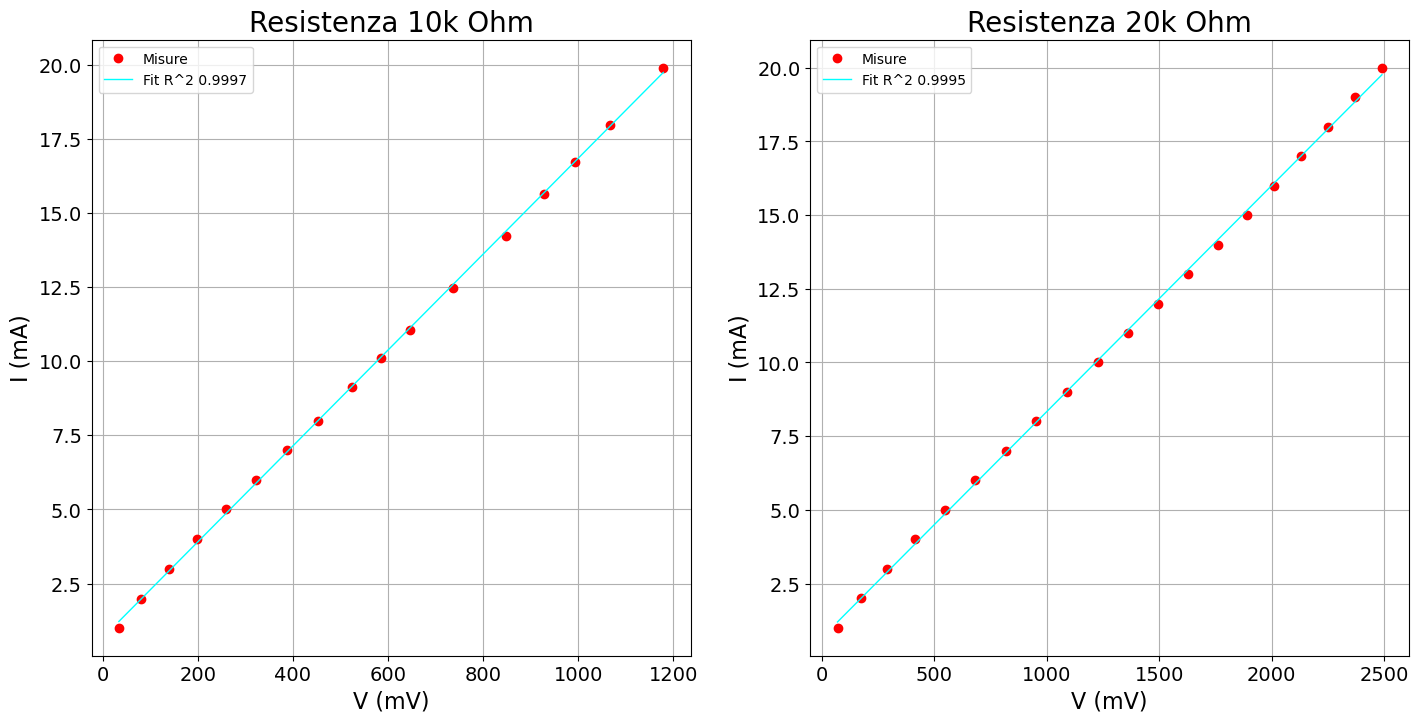

In [88]:
# In questa cella si procederà con i fit di beta; nei seguenti vettori si salva il risultato
betas = []
V_fondos = []
r_sqs = []

for index, V in enumerate(V_tot):
    I = Is[index]
    R = Rs[index]
    ndata = len(I)

    beta_min, beta_max = 1e-10, 1
    V_fondo_min, V_fondo_max = -5, 5
    min, max = [beta_min, V_fondo_min], [beta_max, V_fondo_max]
    bounds = [min, max]

    #Last element of V returns V_50, so array with 5 volts inversed polarization
    V_5 = V[-1]
    # Si usa una lambda function per fissare il valore di R nella funzione che si chiama per il fit
    # (quindi R non è un parametro di fit)
    popt, pcov=sop.curve_fit(lambda V, beta, V_fondo: lin_Iph(V, beta, V_fondo, R), V_5, I, bounds=bounds)
    beta = popt[0]   # questo è il valore di I0 che risulta dal fit
    V_fondo = popt[1]
    betas.append(beta)
    V_fondos.append(V_fondo)

    r_sq = r_squared(I, lin_Iph(V_5, beta, V_fondo, R))
    r_sqs.append(r_sq)

    sigma = np.sqrt(ndata*np.diag(pcov))
    print('Valore fittato per beta=', "{:.3g}".format(beta), 'deviazione standard=',"{:.3g}".format(sigma[0]))
    print('Valore fittato per il fondo=', "{:.3g}".format(V_fondo), 'mV deviazione standard=',"{:.3g}".format(sigma[1]),"mV")
    print("R^2 = ", "{:.5g}".format(r_sq))

# Si predispone il plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[17,8])

ax1.set_title("Resistenza 10k Ohm", size=titlefontsize)
ax1.plot(V_tot[0][-1], Is[0], 'o', markersize=markersize, color="red", label="Misure")
ax1.plot(V_tot[0][-1], lin_Iph(V_tot[0][-1], betas[0], V_fondos[0], Rs[0]), linewidth=linewidth, color="cyan", label="Fit R^2 {:.4f}".format(r_sqs[0]))
ax1.set_xlabel('V (mV)', size=labelfontsize)
ax1.set_ylabel('I (mA)', size=labelfontsize)
ax1.tick_params(labelsize=tickfontsize)
ax1.grid(True)
ax1.legend()

ax2.set_title("Resistenza 20k Ohm", size=titlefontsize)
ax2.plot(V_tot[1][-1], Is[1], 'o', markersize=markersize, color="red", label="Misure")
ax2.plot(V_tot[1][-1], lin_Iph(V_tot[1][-1], betas[1], V_fondos[1], Rs[1]), linewidth=linewidth, color="cyan", label="Fit R^2 {:.4f}".format(r_sqs[1]))
ax2.set_xlabel('V (mV)', size=labelfontsize)
ax2.set_ylabel('I (mA)', size=labelfontsize)
ax2.tick_params(labelsize=tickfontsize)
ax2.grid(True)
ax2.legend();


R =  10000 V_g =  0
Valore fittato per I_0= 5.12e-09 deviazione standard= 9.084e-09
Valore fittato per n= 1.65 deviazione standard= 0.3141

R =  10000 V_g =  -0.5
Valore fittato per I_0= 9.16e-09 deviazione standard= 6.038e-08
Valore fittato per n= 1.72 deviazione standard= 1.42

R =  10000 V_g =  -1
Valore fittato per I_0= 8.09e-09 deviazione standard= 2.74e-06
Valore fittato per n= 1.01 deviazione standard= 51.89

R =  10000 V_g =  -3
Valore fittato per I_0= 3.68e-09 deviazione standard= 4.541e-06
Valore fittato per n= 5 deviazione standard= 0

R =  10000 V_g =  -5
Valore fittato per I_0= 3.84e-09 deviazione standard= 4.509e-06
Valore fittato per n= 3 deviazione standard= 0

R =  20000 V_g =  0
Valore fittato per I_0= 2.86e-09 deviazione standard= 2.974e-09
Valore fittato per n= 1.56 deviazione standard= 0.158

R =  20000 V_g =  -0.5
Valore fittato per I_0= 3.29e-09 deviazione standard= 6.387e-09
Valore fittato per n= 1.54 deviazione standard= 0.3039

R =  20000 V_g =  -1
Valore fit

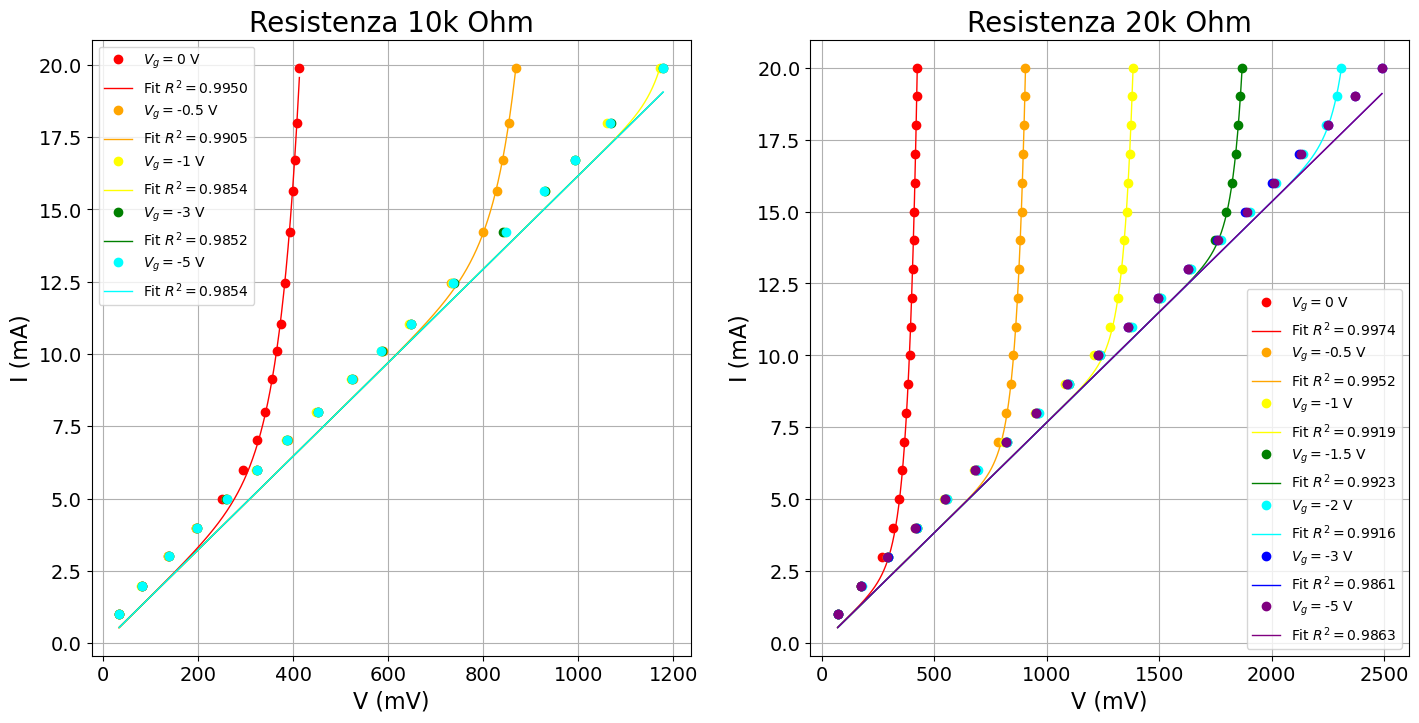

In [89]:
# Qui si procede con i fit della curva completa
#for index, V in enumerate(V_tot):
#    I = Is [index]
#    R = Rs[index]
#    V_g = V_gs[index]
#    beta = betas[index]
#    ndata=len(I)

I_0_min, I_0_max = 1e-10, 5
n_min, n_max = 1, 5
min, max = [I_0_min, n_min], [I_0_max, n_max]
bounds = [min, max]

# plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[17,8])

#procedura per la resistenza da 10k
#v_curr sta per v corrente, cioè i potenziali misurati per la V_g che si sta considerando
for index, v_curr in enumerate(V_tot[0]):
    ndata=len(v_curr)
    #si dividono per 1000 i vettori perche siamo in mV e mA, ma le costanti fondamentali salvate sopra sono nel sistema internazionale
    popt, pcov = sop.curve_fit(lambda v, I_0, n: complete_curve(v, I_0, n, V_gs[0][index], betas[0], Rs[0]), v_curr/1000, Is[0]/1000, bounds=bounds)
    I_0 = popt[0]   # questo è il valore di I0 che risulta dal fit
    n = popt[1]
    sigma = np.sqrt(ndata*np.diag(pcov))
    print("\nR = ", Rs[0], "V_g = ", V_gs[0][index])
    print('Valore fittato per I_0=', "{:.3g}".format(I_0), 'deviazione standard=',"{:.4g}".format(sigma[0]))
    print('Valore fittato per n=', "{:.3g}".format(n), 'deviazione standard=',"{:.4g}".format(sigma[1]))

    r_sq = r_squared(Is[0]/1000, complete_curve(v_curr/1000, I_0, n, V_gs[0][index], betas[0], Rs[0]))

    xmin, xmax = v_curr[0], v_curr[-1]
    x = np.arange(xmin,xmax+1e-5,0.01)
    #si moltiplica per 1000 alla fine per tornare in mA
    y = complete_curve(x/1000, I_0, n, V_gs[0][index], betas[0], Rs[0])*1000

    ax1.plot(v_curr, Is[0], 'o', markersize=markersize, linewidth=linewidth, color=colors[index], label="$V_g = $"+str(V_gs[0][index])+" V")
    ax1.plot(x, y, linewidth=linewidth, color=colors[index], label="Fit $R^2 =${:.4f}".format(r_sq))


ax1.set_title("Resistenza 10k Ohm", size=titlefontsize)
ax1.set_xlabel('V (mV)', size=labelfontsize)
ax1.set_ylabel('I (mA)', size=labelfontsize)
ax1.tick_params(labelsize=tickfontsize)
ax1.grid(True)
ax1.legend()

ax2.set_title("Resistenza 20k Ohm", size=titlefontsize)
for index, v_curr in enumerate(V_tot[1]):
    ndata=len(v_curr)
    #si dividono per 1000 i vettori perche siamo in mV e mA, ma le costanti fondamentali salvate sopra sono nel sistema internazionale
    popt, pcov = sop.curve_fit(lambda v, I_0, n: complete_curve(v, I_0, n, V_gs[1][index], betas[1], Rs[1]), v_curr/1000, Is[1]/1000, bounds=bounds)
    I_0 = popt[0]   # questo è il valore di I0 che risulta dal fit
    n = popt[1]
    sigma = np.sqrt(ndata*np.diag(pcov))
    print("\nR = ", Rs[1], "V_g = ", V_gs[1][index])
    print('Valore fittato per I_0=', "{:.3g}".format(I_0), 'deviazione standard=',"{:.4g}".format(sigma[0]))
    print('Valore fittato per n=', "{:.3g}".format(n), 'deviazione standard=',"{:.4g}".format(sigma[1]))

    r_sq = r_squared(Is[1]/1000, complete_curve(v_curr/1000, I_0, n, V_gs[1][index], betas[1], Rs[1]))

    xmin, xmax = v_curr[0], v_curr[-1]
    x = np.arange(xmin,xmax+1e-5,0.01)
    #si moltiplica per 1000 alla fine per tornare in mA
    y = complete_curve(x/1000, I_0, n, V_gs[1][index], betas[1], Rs[1])*1000

    ax2.plot(v_curr, Is[1], 'o', markersize=markersize, linewidth=linewidth, color=colors[index], label="$V_g = $"+str(V_gs[1][index])+" V")
    ax2.plot(x, y, linewidth=linewidth, color=colors[index], label="Fit $R^2 =${:.4f}".format(r_sq))

ax2.set_xlabel('V (mV)', size=labelfontsize)
ax2.set_ylabel('I (mA)', size=labelfontsize)
ax2.tick_params(labelsize=tickfontsize)
ax2.grid(True)
ax2.legend();

Su questi ultimi fit c'è da fare un'osservazione importante: per valori bassi (in valore assoluto) di $V_g$ i fit si comportano bene dando risultati soddisfacenti. Per valori più alti ($V_g \leq -1$ nella resistenza da 10k e $V_g \leq -2$ nella resistenza da 20k$) la deviazione standard riportata dall'algoritmo di fit sale a livelli anomali (e indubbiamente errati): una possibile spiegazione di questo comportamento potrebbe essere che, al rettificarsi della relazione (dovuta all'aumentare della polarizzazione inversa), l'algoritmo di fit non riesca a ricavare valori esatti per la deviazione standard. Guardando però i valori del fattore R^2, i valori assoluti fittati per i parametri sembrano soddisfacenti.